# QST-CGAN performance on actual experimental data of Wigner function

Reconstructing a `binomial` state from measurements of the Wigner function.
The specific `binomial` state we consider is defined as:

$$|\psi_{\text{binomial}} \rangle = \frac{1}{\sqrt 2} ( |0 \rangle + |4 \rangle \big ) $$


## Wigner function measurements

The Wigner function can be obtained by calculating the expectation value of
the following operator (displaced parity):

$$\mathcal O_i = \frac{2}{\pi} D(-\beta_i) [\sum_n (-1)^n|n\rangle \langle n]|D^{\dagger}(-\beta_i)$$

where $\beta_i$ are complex-valued points in the phase space.


In [29]:
import numpy as np

from qutip import expect, displace, fock_dm
from qutip.wigner import wigner


import tensorflow as tf

from tqdm.auto import tqdm

from qst_cgan.ops import convert_to_real_ops, batched_expect, tf_fidelity
from qst_cgan.gan import generator_loss, discriminator_loss, Generator, Discriminator


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from dataclasses import dataclass

%load_ext autoreload
tf.keras.backend.set_floatx('float64') # Set float64 as the default

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


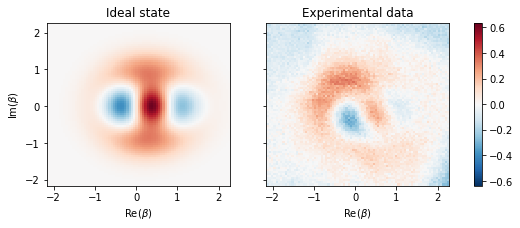

In [39]:
hilbert_size = 32
alpha = 1

psi = coherent(hilbert_size, 1).full()
psi[0] = np.exp(1j*np.pi)*psi[0]
psi[1] = np.exp(1j*np.pi)*psi[1]

psi = Qobj(psi)

xvec = np.load("data/xvector.npy")
yvec = np.load("data/yvector.npy")
w_experimental = np.load("data/wigner_data.npy")

w = wigner(psi, xvec, yvec, g = 2)

cmap = "RdBu_r"

fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharex=True, sharey=True)
im = ax[0].pcolor(xvec, yvec, w, vmin=-2/np.pi, vmax=2/np.pi, cmap=cmap, shading='auto')
im = ax[1].pcolor(xvec, yvec, w_experimental, vmin=-2/np.pi, vmax=2/np.pi, cmap=cmap, shading='auto')
plt.colorbar(im, ax = [ax[0], ax[1]])
ax[0].set_xlabel(r"Re($\beta$)")
ax[1].set_xlabel(r"Re($\beta$)")
ax[0].set_ylabel(r"Im($\beta$)")

ax[0].set_title("Ideal state")
ax[1].set_title("Experimental data")
plt.show()

# Construct the measurement operators and simulated data (without any noise)

Note: This takes some time since we are constructing all the operators for a
grid of 81 x 81 phase space points. There is a possibility of speeding up this
calculating immensely with faster implementations of computing the necessary
operators. 

In [32]:
def wigner_op(hilbert_size: int, beta: complex):
    """Computes the operator for a Wigner function measurement

    Args:
        hilbert_size (int): Hilbert size dimension
        beta (complex): Phase space point
    """
    D = displace(hilbert_size, beta)
    op = sum([((-1)**i)*D*fock_dm(hilbert_size, i)*D.dag() for i in range(hilbert_size)])
    op = (op)*(2/np.pi)
    return op

X, Y = np.meshgrid(xvec, yvec)
betas = (X + 1j*Y).ravel()
m_ops = []

for beta in tqdm(betas):
    m_ops.append(wigner_op(hilbert_size, beta))
    
data = expect(m_ops, psi)

100%|██████████| 6561/6561 [02:58<00:00, 36.85it/s]


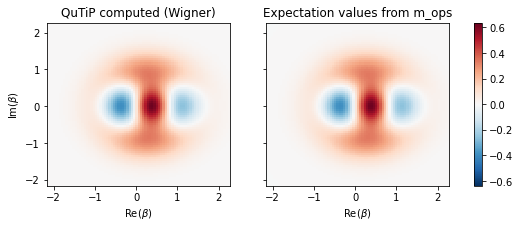

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharex=True, sharey=True)

im = ax[0].pcolor(xvec, yvec, w, vmin=-2/np.pi, vmax=2/np.pi, cmap=cmap, shading='auto')
im = ax[1].pcolor(xvec, yvec, data.reshape(w.shape), vmin=-2/np.pi, vmax=2/np.pi, cmap=cmap, shading='auto')
plt.colorbar(im, ax = [ax[0], ax[1]])

ax[0].set_xlabel(r"Re($\beta$)")
ax[1].set_xlabel(r"Re($\beta$)")
ax[0].set_ylabel(r"Im($\beta$)")

ax[0].set_title("QuTiP computed (Wigner)")
ax[1].set_title("Expectation values from m_ops")
plt.show()

# Selecting the relevant data

We select the data within a region inside the dashed circle where we have
greater confidence in the data

/Users/shahnawaz/miniconda3/envs/qstcgan/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


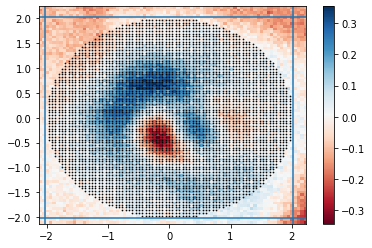

In [94]:
x = np.arange(0, len(xvec))
y = np.arange(0, len(xvec))
arr = np.zeros((y.size, x.size))

# Circle dimensions
cx = 41
cy = 41
r = 37

mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < r**2
possible_index = np.argwhere(mask.ravel()).ravel()

betas_in_circle = betas[possible_index]
data_in_circle = w_experimental.ravel()[possible_index]

im = plt.pcolor(xvec, yvec, w_experimental, cmap="RdBu")
plt.colorbar(im)

plt.axvline(xvec[cx+r])
plt.axvline(xvec[cx-r])

plt.axhline(xvec[cy+r])
plt.axhline(xvec[cy-r])

plt.scatter(np.real(betas_in_circle), np.imag(betas_in_circle), s=.5, c="k")

# Setup the inputs to the neural network - measurement ops and data

We need to convert the QuTiP qunatum objects to TensorFlow objects in order to feed them to the neural network.
We take 4281 operators (32 x 32 grid of complex $\beta$ values in the phase space). Each operator is a complex matrix
of size 32 x 32 since we choose a Hilbert space cutoff of 32. 

Once we convert the measurement operators to a TensorFlow complex tensor, we further separate the real and imaginary parts.
The measurement operators are therefore input as real matrix with the last dimension as (`2 x ` number of operators). We have 1024 operators and therefore the input to the neural networks is a $1 \times  32 \times 32  \times 2048$ dimensional tensor containing the real and imaginary parts of the all the complex-valued measurement operators.

In [95]:
m_ops_in_circle = []

for beta in tqdm(betas_in_circle):
    m_ops_in_circle.append(wigner_op(hilbert_size, beta))

ops_numpy = [op.data.toarray() for op in m_ops_in_circle] # convert the QuTiP Qobj to numpy arrays
ops_tf = tf.convert_to_tensor([ops_numpy]) # convert the numpy arrays to complex TensorFlow tensors

print(ops_tf.shape, ops_tf.dtype)
A = convert_to_real_ops(ops_tf) # convert the complex-valued numpy matrices to real-valued TensorFlow tensors

100%|██████████| 4281/4281 [02:01<00:00, 35.14it/s]


(1, 4281, 32, 32) <dtype: 'complex128'>


# Training the Conditional Generative Adversarial Network (CGAN)

We construct a `Generator` and a `Discriminator` using TensorFlow and train them for state reconstruction in an adversarial fashion. The inputs to the CGAN are the data (`x`) and the measurement operators converted as real matrices `A`. 

In [96]:
x = tf.convert_to_tensor(data_in_circle.reshape(1, -1))
num_measurements = x.shape[-1]

generator = Generator(hilbert_size, num_measurements, noise=0.0) # Specify the number of measurement settings and Gaussian noise
discriminator = Discriminator(hilbert_size, num_measurements)

## Generator

In [97]:
generator.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 4281)]       0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 512)          2191872     inputs[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_25 (LeakyReLU)      (None, 512)          0           dense_25[0][0]                   
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 16, 16, 2)    0           leaky_re_lu_25[0][0]             
___________________________________________________________________________________________

## Discriminator

In [98]:
print(discriminator.summary())

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 4281)]       0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 4281)]       0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 8562)         0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 128)          1096064     concatenate_5[0][0]       

# Training

We train the networks using TensorFlow optimizers and record the loss function as well as intermediate density matrices during training. In order to get the intermediate density matrices, we construct a `density matrix` model called `model_dm` model that outputs the density matrix using the generator.

In [99]:
density_layer_idx = None

for i, layer in enumerate(generator.layers):
    if "density_matrix" in layer._name:
        density_layer_idx = i
        break

print(density_layer_idx)
model_dm = tf.keras.Model(inputs=generator.input, outputs=generator.layers[density_layer_idx].output)

@dataclass
class LossHistory:
    """Class for keeping track of loss"""
    generator: list
    discriminator: list
    l1: list

loss = LossHistory([], [], [])
fidelities = []

17


In [100]:
initial_learning_rate = 0.0005

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate,
                                                     decay_steps=100,
                                                     decay_rate=0.96,
                                                     staircase=False)

lam = 100.

generator_optimizer = tf.keras.optimizers.Adam(lr_schedule, 0.5, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr_schedule, 0.5, 0.5)

max_iterations = 100


# Reconstruction using QST-CGAN

Note that we are comparing fidelity to the ideal state which is clearly going 
to be rather poor sin

In [101]:
def train_step(A, x):
    """Takes one step of training for the full A matrix representing the
    measurement operators and data x.

    Note that the `generator`, `discriminator`, `generator_optimizer` and the
    `discriminator_optimizer` has to be defined before calling this function.

    Args:
        A (tf.Tensor): A tensor of shape (m, hilbert_size, hilbert_size, n x 2)
                       where m=1 for a single reconstruction, and n represents
                       the number of measured operators. We split the complex
                       operators as real and imaginary in the last axis. The 
                       helper function `convert_to_real_ops` can be used to
                       generate the matrix A with a set of complex operators
                       given by `ops` with shape (1, n, hilbert_size, hilbert_size)
                       by calling `A = convert_to_real_ops(ops)`.

        x (tf.Tensor): A tensor of shape (m, n) with m=1 for a single
                       reconstruction and `n` representing the number of
                       measurements. 
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator([A, x], training=True)

        disc_real_output = discriminator([A, x, x], training=True)
        disc_generated_output = discriminator([A, x, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, x, lam=lam
        )
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(
        gen_total_loss, generator.trainable_variables
    )
    discriminator_gradients = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(generator_gradients, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(discriminator_gradients, discriminator.trainable_variables)
    )

    loss.generator.append(gen_gan_loss)
    loss.l1.append(gen_l1_loss)
    loss.discriminator.append(disc_loss)


pbar = tqdm(range(max_iterations))
for i in pbar:
    train_step(A, x)
    density_matrix = model_dm([A, x])
    f = tf_fidelity(density_matrix, rho_tf)[-1]
    fidelities.append(f)
    pbar.set_description("Fidelity {} | Gen loss {} | L1 loss {} | Disc loss {}".format(f, loss.generator[-1], loss.l1[-1], loss.discriminator[-1]))

Fidelity 0.3119083420136976 | Gen loss 3.2680859565734863 | L1 loss 0.018959046425101603 | Disc loss 0.1529691480100155: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


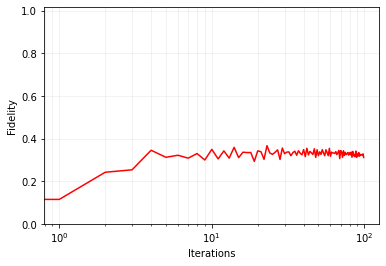

In [102]:
iterations = np.arange(len(fidelities))
plt.plot(iterations, fidelities, color="red", label="QST-CGAN")
plt.xlabel("Iterations")
plt.ylabel("Fidelity")
plt.ylim(0, 1.02)
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.2)
plt.xscale('log')
plt.show()

In [103]:
density_matrix = model_dm([A, x])
rho_reconstructed = Qobj(density_matrix.numpy().reshape(hilbert_size, hilbert_size))

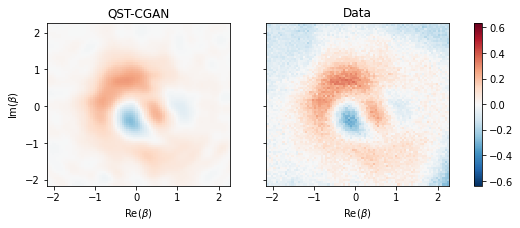

In [105]:
w_reconstructed = wigner(rho_reconstructed, xvec, yvec, g = 2)

cmap = "RdBu_r"

fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharex=True, sharey=True)
im = ax[0].pcolor(xvec, yvec, w_reconstructed, vmin=-2/np.pi, vmax=2/np.pi, cmap=cmap, shading='auto')
im = ax[1].pcolor(xvec, yvec, w_experimental, vmin=-2/np.pi, vmax=2/np.pi, cmap=cmap, shading='auto')
plt.colorbar(im, ax = [ax[0], ax[1]])
ax[0].set_xlabel(r"Re($\beta$)")
ax[1].set_xlabel(r"Re($\beta$)")
ax[0].set_ylabel(r"Im($\beta$)")

ax[0].set_title("QST-CGAN")
ax[1].set_title("Data")
plt.show()